In [1]:
import tensorflow as tf
import zfit
from zfit import z

In [2]:
import random
import json
import pandas as pd
from time import time

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.optimize import minimize


import SLSQP_zfit
import time
#import progressbar # quitar

import scipy
from scipy.stats import binom
%config Completer.use_jedi = False

import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

## $ \text{input }F_{H} \in {\rm I\!R} \rightarrow \text{C}(m, \cos(\theta) \mid F_{H}, Y_{s}, Y_{b}) \rightarrow [(x_{0},...,x_{n})_{0},...,(x_{0},...,x_{n})_{N}] $

## $ [(x_{0},...,x_{n})_{0},...,(x_{0},...,x_{n})_{N}] \rightarrow [( \Delta \chi^{2}_{toys})_{0},...,( \Delta \chi^{2}_{toys})_{N}] \rightarrow \text{ list of } \Delta \chi^{2}_{toys}      $

# $ \text{input Dictionary with params and real data} = $

# $ \{ \text{real_data } : ((x_{0},y_{0}),...,(x_{n},y_{n}))_{real}, \text{params } : (param_{1},..., param_{k}) \}  $

# or

# $ \text{input Dictionary with params and real data} = $

### $ \{ \text{real_data } : \{    event_{0} : value_{0}  ,...,  event_{n} : value_{n} \}  , \text{params } : \{ param_{0} : \mu_{0}, param_{1} : \sigma_{0},..., param_{k} : \lambda) \}  $

# $ (x_{0},...,x_{n})_{real}  \rightarrow \Delta \chi^{2}_{data} \in {\rm I\!R} $

# $1-CL = \frac{  N(   [( \Delta \chi^{2}_{toys})_{0},...,( \Delta \chi^{2}_{toys})_{N}]  >  \Delta \chi^{2}_{data}      ) }{    N} $

# $\text{ouput } 1-CL $.

In [3]:
BIN = 4
#with open(f'Bin{BIN}.json') as f:
with open(f'testBin.json') as f:
    params = json.load(f)

In [4]:
df_obs = pd.read_pickle("df_complete_obs")
data_obs = zfit.Data.from_pandas(df_obs)
df_obs.head()
print(data_obs)

<zfit.Data: Data obs=('BMass', 'cosThetaKMu')>


In [5]:
params

{'Signal': {'yield': 79.23010349768056,
  'mass': {'Gaussian+CrystalBall': {'muCB': 5.279413612173776,
    'alphaCB': 2.0955,
    'sigmaCB': 0.02799382172580174,
    'nCB': 1.0057,
    'muGauss': 5.279413612173776,
    'sigmaGauss': 0.05771537244498789,
    'fracCB': 0.4224069260942781}},
  'angle': {'FH': 0.3825,
   'BernEffyCoefs': [7.58628405261863e-06,
    8.386121789771828e-06,
    1.1543309862971363e-05]}},
 'Background': {'yield': 86.77177895777007,
  'mass': {'Exponential+Gauss': {'mu': 5.000000008458439,
    'sigma': 0.09787990155995803,
    'lambda_': -0.02581664674416828,
    'fraction_exp': 0.6346521270418675}},
  'angle': {'2SideBands': {'left_sb': [4.39e-06, 7.11e-06, 1.15e-05],
    'right_sb': [1.133e-05,
     3.959e-06,
     2.383e-05,
     1.595e-05,
     1.049e-13,
     1.178e-05],
    'fraction': 0.6346521270418675}}},
 'limits': [5.0, 6.0]}

In [6]:
def f(FH, parameters, real_data):
    
    """
    Function that return a 1-CL point with float FH and dictionary = {params, real data} as arguments
    """
    
    # Model building
    
    class Angular_PDF(zfit.pdf.BasePDF):
        """ Angular pdf with one parameter from equation (7.2).
    
        """

        def __init__(self, obs, FH, name="Angular_pdf", ):
        
            params = {'FH': FH}
            super().__init__(obs, params, name=name)

        def _pdf(self, x, norm_range):
        
            cos_l = z.unstack_x(x)
            FH = self.params['FH']

            pdf = 3/2*(1 - FH)*(1 - tf.math.square(tf.math.abs(cos_l))) + FH
        
            return pdf
    
    class bernstein(zfit.pdf.BasePDF):  
        """
        Bernstein_nth Degree
        From a to b
        x-> (x-a/b-a)
        https://en.wikipedia.org/wiki/Bernstein_polynomial
        """
    
        def __init__(self, coefs, obs, name="Bernstein" ):        
            
            self.degree = len(coefs)-1
            params = dict()
            for indx,c in enumerate(coefs):
                params[f'c{indx}'] = c

            super().__init__(obs, params, name=name+f' Deg. {self.degree}')


        def _unnormalized_pdf(self, x):
            
            x_ = zfit.ztf.unstack_x(x)
            limits = self.norm_range.limit1d
            x_T  = (x_-limits[0])/(limits[1]-limits[0])
            deg = self.degree
    
            basis = dict()
            
            for i in range(deg+1):
                basis[i] = self.params[f'c{i}']*scipy.special.binom(deg,i)*tf.pow(x_T,i)*tf.pow(1-x_T,deg-i)

            pdf = basis[0]
            
            for i in range(1, deg+1):
                pdf += basis[i]

            return pdf
    
    
    cos = zfit.Space(obs='cosThetaKMu', limits=[-1,1])
    mass = zfit.Space(obs='BMass', limits=[5,6.0])


    fh = zfit.Parameter('F_HH', FH, lower_limit=0.0, upper_limit=3.0)  
    decay = Angular_PDF(FH=fh, obs=cos)

    efficiency = zfit.pdf.Chebyshev(obs=cos, 
    coeffs=params['Signal']['angle']['Chi2EffyCoefs'][1:]) # Bernstein grado variable

    decay_eff = zfit.pdf.ProductPDF(pdfs=[decay, efficiency], obs=cos)

    c1_poly = 1.04610E-5
    c2_poly = 4.26775E-6
    c3_poly = 2.00905E-5
    c4_poly = 7.88229E-6

    c1 = zfit.Parameter("c1", c1_poly, floating=False)
    c2 = zfit.Parameter("c2", c2_poly, floating=False)
    c3 = zfit.Parameter("c3", c3_poly, floating=False)
    c4 = zfit.Parameter("c4", c4_poly, floating=False)

    coef_list = [c1, c2, c3, c4]

    background_angular = bernstein(coefs=coef_list, obs=cos) # Suma de dos polinomios de grado variable  

    mass_signal_params = params['Signal']['mass']['2Gaussian+CrystalBall']

    signalCB = zfit.pdf.CrystalBall(mu=mass_signal_params['muCB'],  # Gauss + CB
                                sigma=mass_signal_params['sigmaCB'], 
                                alpha=mass_signal_params['alphaCB'], 
                                n=mass_signal_params['nCB'], 
                                obs=mass, 
                                name='signal_CrystalBall')

    signalG1 = zfit.pdf.Gauss(mu=mass_signal_params['muGauss'], 
                          sigma=mass_signal_params['sigmaGauss1'], 
                          obs=mass, 
                          name='signal_Gaussian1')

    signalG2 = zfit.pdf.Gauss(mu=mass_signal_params['muGauss'], 
                          sigma=mass_signal_params['sigmaGauss2'], 
                          obs=mass, 
                          name='signal_Gaussian2')

    fracs = mass_signal_params['fracCB'], mass_signal_params['fracGauss1'], mass_signal_params['fracGauss2']

    signal_mass = zfit.pdf.SumPDF([signalCB, signalG1, signalG2], fracs=[fracs[0]/sum(fracs), fracs[1]/sum(fracs)], 
                      name='signal_CB+2Gauss')


    mass_background_params = params['Background']['mass']['Exponential+Gauss']

    
    backExponential = zfit.pdf.Exponential(lambda_=mass_background_params['lambda_'], 
                            obs=mass,
                            name='background_Exponential')

    backBGauss = zfit.pdf.Gauss(mu=mass_background_params['mu'],
                            sigma=mass_background_params['sigma'],
                            obs=mass,
                            name='background_Gaussian')

    background_mass = zfit.pdf.SumPDF([backExponential, backBGauss], fracs=mass_background_params['fraction_exp'], 
                          name='background_Gauss+Exp')


    complete_signal = signal_mass*decay_eff
    complete_background = background_mass*background_angular


    s_ini = 437
    b_ini = 706 

    Total = s_ini + b_ini

    S = zfit.Parameter('signalYield', s_ini, 0, Total)
    B = zfit.Parameter('backgroundYield', b_ini, 0, Total)

    signal_extended = complete_signal.create_extended(yield_=S)
    background_extended = complete_background.create_extended(yield_=B)

    complete_pdf = signal_extended+background_extended
    print(complete_pdf.get_params())
    
    N = 50 # Number of toy MC
    
    pseudo_data = []
    
    for i in range(N):
        
        sampler = complete_pdf.create_sampler(n=Total, fixed_params=True)
        sampler.resample()
        pseudo_data.append(sampler)
        
        if i%2 ==0:
                zfit.util.cache.clear_graph_cache()

    
    constAngParams_Full = ({'type': 'ineq', 'fun': lambda x:  x[2]},
                       {'type': 'ineq', 'fun': lambda x:  3-x[2]}) 

    SLSQP_FULL = SLSQP_zfit.SLSQP(constraints=constAngParams_Full)

    
    SLSQP_FULL_profile = SLSQP_zfit.SLSQP() # Without restrictions on POI's
    
    
    Delta_chi2 = []
        
    for i in range(N):
        
        fh.set_value(FH)
        S.set_value(s_ini)
        B.set_value(b_ini)
        
        data = pseudo_data[i]
        
        nll_best = zfit.loss.ExtendedUnbinnedNLL(model=complete_pdf, data=data)
        result_best = SLSQP_FULL.minimize(nll_best)
        best_likelihood = nll_best.value().numpy() 

        
        
        fh.set_value(FH)
        S.set_value(s_ini)
        B.set_value(b_ini)
        
        nll_profile = zfit.loss.ExtendedUnbinnedNLL(model=complete_pdf, data=data)
        result_profile = SLSQP_FULL_profile.minimize(nll_profile, params=(S,B))
        profile_likelihood = nll_profile.value().numpy() 
    
        Delta = profile_likelihood - best_likelihood
        Delta_chi2.append(Delta)
        
        if i%2 ==0:
            zfit.util.cache.clear_graph_cache()
        
    print(plt.hist(Delta_chi2))
    
    # Delta chi2 data
    
    fh.set_value(FH)
    S.set_value(s_ini)
    B.set_value(b_ini)
    
    nll_obs_best = zfit.loss.ExtendedUnbinnedNLL(model=complete_pdf, data=real_data)
    result_obs_best = SLSQP_FULL.minimize(nll_obs_best)
    b_likelihood = nll_obs_best.value().numpy()
    
    print(b_likelihood)
    
    fh.set_value(FH)
    S.set_value(s_ini)
    B.set_value(b_ini)
        

    nll_obs_profile = zfit.loss.ExtendedUnbinnedNLL(model=complete_pdf, data=real_data)
    result_obs_profile = SLSQP_FULL_profile.minimize(nll_obs_profile, params=(S,B))
    p_likelihood = nll_obs_profile.value().numpy()
    
    print(p_likelihood)
    
    
    Delta_data = p_likelihood - b_likelihood
    
    print(Delta_data)
    
    factor = []
    
    for i in range(N):
        
        test = Delta_chi2[i]
        
        if test > Delta_data:
            
            factor.append(test)
            
    cl = len(factor)/N
    
    return (FH, cl)
    
        
        
        
    
    
    

/home/gabriel/anaconda3/envs/testenv2/lib/python3.6/site-packages/zfit/core/basepdf.py:440: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  "As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). This"


OrderedSet([<zfit.Parameter 'signalYield' floating=True value=79>, <zfit.Parameter 'backgroundYield' floating=True value=86>, <zfit.Parameter 'F_HH' floating=True value=0.24>])


/home/gabriel/Documents/trabajo/b0/ConfidenceIntervalsFC/confidence_intervals.py:68: UserWarning: The function <function Space.limit1d at 0x7fde157ec6a8> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('cosThetaKMu',), axes=(0,), limits=(array([[0.]]), array([[1.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  limits = self.norm_range.limit1d


ftol not in minizer_options
ftol not in minizer_options


/home/gabriel/anaconda3/envs/testenv2/lib/python3.6/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


(array([32.,  7.,  4.,  3.,  1.,  2.,  0.,  0.,  0.,  1.]), array([2.08481993e-07, 4.42533011e-01, 8.85065814e-01, 1.32759862e+00,
       1.77013142e+00, 2.21266422e+00, 2.65519702e+00, 3.09772983e+00,
       3.54026263e+00, 3.98279543e+00, 4.42532823e+00]), <BarContainer object of 10 artists>)


/home/gabriel/anaconda3/envs/testenv2/lib/python3.6/site-packages/zfit/core/loss.py:159: AdvancedFeatureWarning: Either you're using an advanced feature OR causing unwanted behavior. To turn this warning off, use `zfit.settings.advanced_warnings['inconsistent_fitrange']` = False`  or 'all' (use with care) with `zfit.settings.advanced_warnings['all'] = False
PDFs [<zfit.SumPDF  params=[Composed_autoparam_28, Composed_autoparam_29] dtype=float64>0] as well as `data` [<zfit.core.data.Data object at 0x7fde24c49d30>] have different ranges [(<zfit Space obs=('BMass', 'cosThetaKMu'), axes=(0, 1), limits=(array([[5., 0.]]), array([[6., 1.]]))>, <zfit Space obs=('BMass', 'cosThetaKMu'), axes=(0, 1), limits=None>)] they are defined in. The data range will cut the data while the norm range defines the normalization.
  identifier='inconsistent_fitrange')


-6605.586148116077
-6604.063376333325
1.5227717827519882


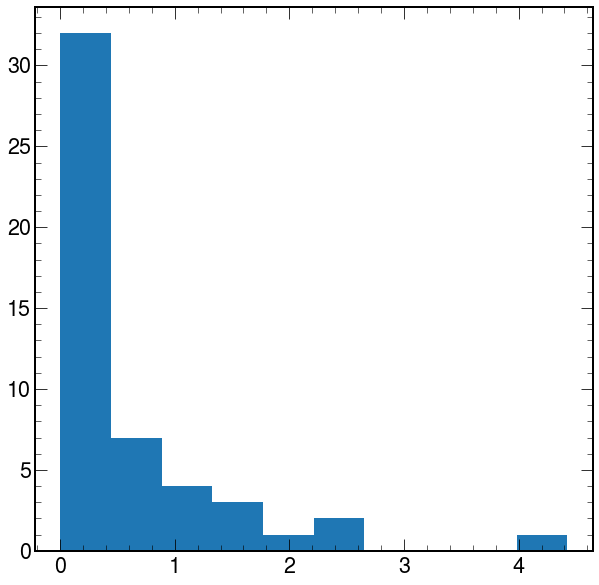

In [7]:
from confidence_intervals import cl_function
#x = f(FH=0.24, parameters=params, real_data=data_obs)
x = cl_function(FH=0.24, params=params, real_data=data_obs)

In [8]:
x

(0.24, 0.12)